In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
import dill
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
lgd = pd.read_csv('../Data/LGD.csv')

In [3]:
lgd.head()

,AcctID,Default_Date,SECSegmentDe_YrMo,SECSubSegmentDe_YrMo,SICIndustryMapDe,CAConcentrationTyDe,RevolveIn,FixedRtIn,default_Balance,ChargeOff_Event,Actual_CO,RecoveryAmt
0,100002233-001,30Jun2013,Commercial and Industrial,Commercial,SERVICE-MEDICAL,NaN,0,1,"US$32,300.00",1,"US$31,725.23","US$16,964.00"
1,100301307-000,30Apr2013,Energy,Service,ENERGY-SERVICE,Energy,0,1,"US$5,908.49",1,"US$5,908.49","US$5,908.49"
2,100302416-001,30Nov2014,Commercial and Industrial,Commercial,SERVICE-MEDICAL,NaN,1,0,"US$7,508.94",1,"US$7,508.94","US$7,508.94"
3,100500347-001,31Mar2016,Commercial and Industrial,Commercial,AGRICULTURE,NaN,0,1,"US$3,565.02",0,"US$3,565.02",US$100.00
4,100601318-005,31Dec2015,Commercial and Industrial,Commercial,MANUFACTURING-OTHER,NaN,1,0,"US$29,901.54",1,"US$29,901.54","US$1,825.85"


In [4]:
lgd['Default_Date'] = pd.to_datetime(lgd['Default_Date'])
lgd['default_Balance'] = lgd.default_Balance.str.replace("[^0-9.]",'', regex = True).astype(float)
lgd['Actual_CO'] = lgd.Actual_CO.str.replace("[^0-9.]",'', regex = True).astype(float)
lgd['RecoveryAmt'] = lgd.RecoveryAmt.str.replace("[^0-9.]",'', regex = True).astype(float)

lgd['recovery_rate'] = (lgd.default_Balance - lgd[['default_Balance', 'Actual_CO']].min(axis = 1) \
                        + lgd['RecoveryAmt']) \
                                    / lgd.default_Balance

In [5]:
lgd['Actual_CO'] = lgd['Actual_CO'].fillna(0)

In [6]:
lgd['recovery_rate'] = np.where(np.logical_and(lgd['Actual_CO'] <= 0, lgd['ChargeOff_Event'] == 1), 0, lgd['recovery_rate'])
lgd['recovery_rate'] = np.where(np.logical_and(lgd['Actual_CO'] <= 0, lgd['ChargeOff_Event'] == 0), 1, lgd['recovery_rate'])
lgd['recovery_rate'] = lgd['recovery_rate'].clip(0,1)

In [7]:
econ = pd.read_csv('../Data/ECON.csv', usecols = lambda x: x in pd.read_csv('../Data/cleaned_data.csv', 
                                                                            nrows = 1).columns.tolist() + ['DATE'])
econ['DATE'] = pd.to_datetime(econ['DATE'])
econ[econ.columns.difference(['DATE'])] = econ[econ.columns.difference(['DATE'])].\
                                            apply(lambda x: pd.Series(x).str.replace('[^0-9.]*', '', 
                                                                                     regex = True).astype(float))

In [8]:
lgd = lgd.merge(econ, left_on = 'Default_Date', right_on = 'DATE').drop(columns = ['DATE'])

In [9]:
lgd.shape

(2307, 70)

In [10]:
X, y = lgd.drop(columns = ['AcctID', 'Default_Date', 'SECSubSegmentDe_YrMo', 'CAConcentrationTyDe',
               'default_Balance', 'ChargeOff_Event', 'Actual_CO', 'RecoveryAmt', 'recovery_rate']), lgd['recovery_rate']

In [11]:
X['SICIndustryMapDe'] = X['SICIndustryMapDe'].str.replace('\-.*', '', regex = True).str.strip()

In [12]:
# ['SICIndustryMapDe', 'RevolveIn', 'FixedRtIn', 'SECSegmentDe_YrMo'] + econ, recovery_rate

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y.round(3),
                                            stratify = pd.cut(y.round(3), [-1, 0, .4, .8, 1], include_lowest = True),
                                            random_state = 1234)

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin

In [15]:
class LGDRegressor(RegressorMixin, BaseEstimator):
    def __init__(self):
        ## Build a pipeline
        self.models = dict()
        self.models['100_or_not'] = LogisticRegression(random_state = 1234, max_iter = 800, class_weight = {0 : .6, 1 : .4})
        
        self.models['0_or_not'] = LogisticRegression(random_state = 1234, max_iter = 1000, class_weight = {0: .9, 1: .1})
        
        self.models['gt_0_lt_100'] = MLPRegressor(random_state = 1234, activation = 'identity', hidden_layer_sizes = 1, 
                                                  alpha = 1, max_iter = 1000, learning_rate = 'adaptive', warm_start = True
                                            )

    def fit(self, X, y):
        self.models['100_or_not'].fit(X, (y == 1).astype(int))
        X, y = X[y != 1], y[y != 1]
        self.models['0_or_not'].fit(X, (y != 0).astype(int))
        X, y = X[y != 0], y[y != 0]
        self.models['gt_0_lt_100'].partial_fit(X, y)
        self.models["gt_0_lt_100"].out_activation_ = "logistic"
        self.models['gt_0_lt_100'].fit(X, y)
        return self
    
    def predict(self, X):
        y_pred_100 = self.models['100_or_not'].predict_proba(X)
        y_pred_0 = self.models['0_or_not'].predict_proba(X)
        y_pred_inbtw = self.models['gt_0_lt_100'].predict(X).clip(0, 1)
        return y_pred_100[:, 1] + \
                    y_pred_100[:, 0] * y_pred_0[:, 1] + \
                    y_pred_100[:, 0] * y_pred_0[:, 0] * y_pred_inbtw

In [16]:
column_transformer = ColumnTransformer([
                        ('Categorical_Encoder', OneHotEncoder(drop = 'if_binary', sparse_output = False, 
                                         handle_unknown = 'infrequent_if_exist', min_frequency = .02, max_categories = 8,
                                         feature_name_combiner = 
                                                      lambda feature, val: 
                                                          feature + "_infrequent" if val.startswith('infrequent') \
                                                                                    else val
                                    ), ['SECSegmentDe_YrMo', 'SICIndustryMapDe']),
                        ('Normalizer', PowerTransformer(), X.select_dtypes(np.number).columns.tolist()),
                    ], verbose_feature_names_out = False, verbose = True)
        
LGD_model = Pipeline([('column_transformer', column_transformer),
                     ('LGDRegressor', LGDRegressor())])

In [17]:
LGD_model.fit(X_train, y_train)

[ColumnTransformer]  (1 of 2) Processing Categorical_Encoder, total=   0.0s
[ColumnTransformer] .... (2 of 2) Processing Normalizer, total=   0.1s


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('Categorical_Encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                feature_name_combiner=<function <lambda> at 0x00000191FC5C5F80>,
                                                                handle_unknown='infrequent_if_exist',
                                                                max_categories=8,
                                                                min_frequency=0.02,
                                                                sparse_output=False),
                                                  ['SECSegmentDe_YrMo',
                                                   'SICIndustryMapDe']),
                                                 ('Normalizer',
                                                  PowerTransforme...
                                                   'DJIA_Index_MoM_LQ3',
                                                   'DJIA_Index_MoM_LQ4',
                                                   'CRE_Index_MoM_LQ4',
                                                   'WTI_Oil_Price_MoM_LQ1',
                                                   'WTI_Oil_Price_MoM_LQ2',
                                                   'WTI_Oil_Price_MoM_LQ3',
                                                   'WTI_Oil_Price_MoM_LQ4',
                                                   'GDP_Nominal_QoQ_LQ3',
                                                   'GDP_Nominal_QoQ_LQ4',
                                                   'Unemp_Claims_QoQ_LQ2',
                                                   'Unemp_Claims_QoQ_LQ3',
                                                   'Unemp_Claims_QoQ_LQ4', ...])],
                                   verbose=True,
                                   verbose_feature_names_out=False)),
                ('LGDRegressor', LGDRegressor())])

In [18]:
preds = LGD_model.predict(X_test)

<Axes: xlabel='y_test', ylabel='y_pred'>

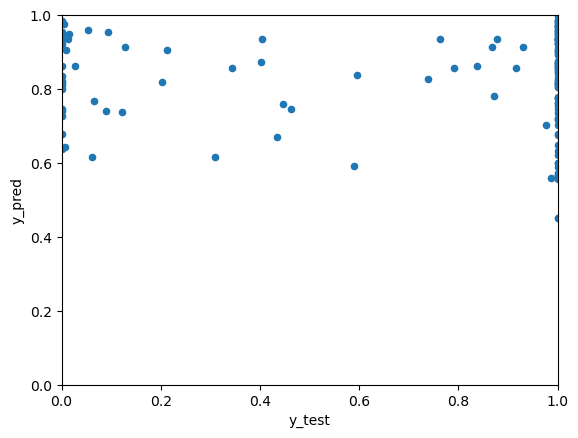

In [19]:
pd.DataFrame([y_test, preds], ['y_test', 'y_pred']).T.plot.scatter(x = 'y_test', y = 'y_pred',xlim = (0, 1), ylim = (0, 1))

In [20]:
pd.Series(preds).describe()

count    577.000000
mean       0.817322
std        0.139329
min        0.368539
25%        0.739574
50%        0.862530
75%        0.929125
max        0.996796
dtype: float64

In [21]:
print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))
print(root_mean_squared_error(y_test, preds))
print(mean_absolute_error(y_test, preds))
print(mean_absolute_percentage_error(y_test, preds))

0.19618837547386625
0.11888477621722203
0.3447967172367249
0.2502269212423917
317617612391566.6


In [22]:
with open('../Models/LGD_model.pkl', 'wb') as f:
    dill.dump(LGD_model, f)